# a run of the full pipeline on the dataset

In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["text.usetex"] = True
plt.rcParams["figure.dpi"] = 125

In [3]:
%load_ext autoreload
%autoreload 2

## reading in training data

In [52]:
import yaml

with open("../default_config.yaml") as f:
    config = yaml.load(f.read())

In [53]:
train_dir = config["train_dir"]
val_dir = config["val_dir"]

num_train=50
num_val=20

print("Reading in data...")

train_data = NucleiDataset(train_dir).load(num_train)
val_data = NucleiDataset(val_dir).load(num_val)

Reading in data...


50image [00:01, 36.70image/s]
20image [00:00, 40.91image/s]


In [77]:
x_train = train_data.images_
y_train = train_data.masks_  # value in 0, 1, ..., n
y_train_bin = (y_train > 0).astype(y_train.dtype)  # value in {0, 1}
x_val = val_data.images_
y_val = val_data.masks_
y_val_bin = (y_val > 0).astype(y_val.dtype)

print("Preprocessing data...")

preprocesser = Preprocesser()

x_train_pre = preprocesser.fit_transform(x_train)
x_val_pre = preprocesser.transform(x_val)

Preprocessing data...


In [56]:
from skimage.morphology import disk

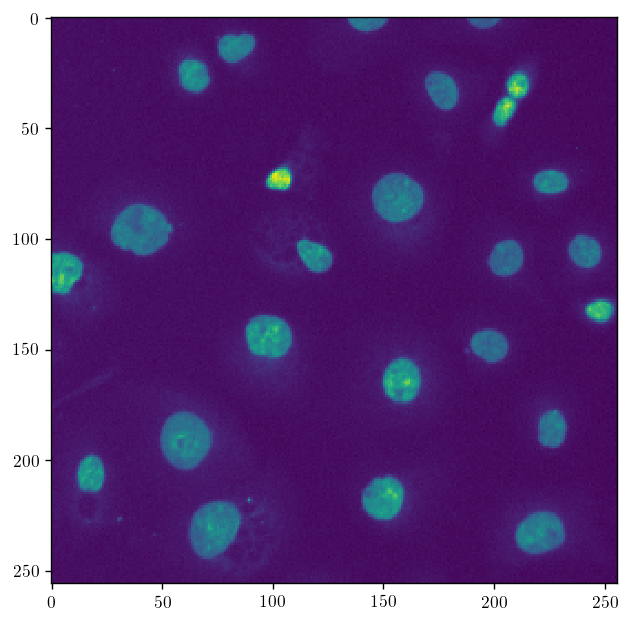

In [80]:
plt.imshow(x_train_pre[9, :, :, 0])

In [134]:
bilateral_d = 2
bilateral_sigma_color = 75
bilateral_sigma_space = 75
equalize_hist_clip_limit = 0.03
dialation_kernel = disk(radius=3)
dialation_iters = 1

print("Transforming data...")

transformer = BasisTransformer(
    bilateral_d=bilateral_d,
    bilateral_sigma_color=bilateral_sigma_color,
    bilateral_sigma_space=bilateral_sigma_space,
    equalize_hist_clip_limit=equalize_hist_clip_limit,
    dialation_kernel=dialation_kernel,
    dialation_iters=dialation_iters)

x_train_feat = transformer.fit_transform(x_train_pre)
x_val_feat = transformer.fit_transform(x_val_pre)

  6%|▌         | 3/50 [00:00<00:01, 25.48pair/s]

Transforming data...


100%|██████████| 20/20 [00:00<00:00, 38.84pair/s]


In [89]:
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor
from deton8.models import MiniBatchRegressor

In [135]:
sgd_params = {
    "regressor":
    SGDRegressor(
        penalty='elasticnet', l1_ratio=0.11, max_iter=5, tol=None),
    "batch_size":
    1000,
    "num_iters":
    25000,
}
pa_params = {
    "regressor": PassiveAggressiveRegressor(C=.2, max_iter=5, tol=None),
    "batch_size": 1000,
    "num_iters": 25000,
}

sgd = MiniBatchRegressor(**sgd_params)
pa = MiniBatchRegressor(**pa_params)

print("Fitting linear models...")

sgd.fit(x_train_feat, y_train_bin)
pa.fit(x_train_feat, y_train_bin)

  0%|          | 110/25000 [00:00<00:22, 1096.53iteration/s]

Fitting linear models...


100%|██████████| 25000/25000 [00:09<00:00, 2555.42iteration/s]


MiniBatchRegressor(batch_size=1000, num_iters=25000,
          regressor=PassiveAggressiveRegressor(C=0.2, average=False, epsilon=0.1,
              fit_intercept=True, loss='epsilon_insensitive', max_iter=5,
              n_iter=None, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False),
          verbose=False)

In [136]:
x_train_extended = extend_features(x_train_feat, sgd, pa)
x_val_extended = extend_features(x_val_feat, sgd, pa)

In [151]:
from deton8.models import UNet

In [152]:
#   Now we train UNet
numchannels = x_train_extended.shape[-1]
unet_config = {
    "numchannels": numchannels,
    "epochs": 50,
    "callbacks": [],
}
unet = UNet(**unet_config)

unet.load_weights("../weights/unet_weights.h5")

print("Fitting UNet...")

unet.fit(x_train_extended, y_train_bin, x_val_extended, y_val_bin)

#   begin inference and print out test scores
x_train_pred = unet.predict(x_train_extended)
x_val_pred = unet.predict(x_val_extended)

Tensor("conv2d_108_target:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("conv2d_108/Sigmoid:0", shape=(?, 256, 256, 1), dtype=float32)
Successfully loaded weights from ../weights/unet_weights.h5...
Fitting UNet...
Epoch 1/50


/home/gvacaliuc/.virtualenvs/ml3.6/lib/python3.6/site-packages/keras/preprocessing/image.py:857: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (50, 256, 256, 8) (8 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


 7/25 [=======>......................] - ETA: 42s - loss: 0.0000e+00 - acc: 0.9547

KeyboardInterrupt: 

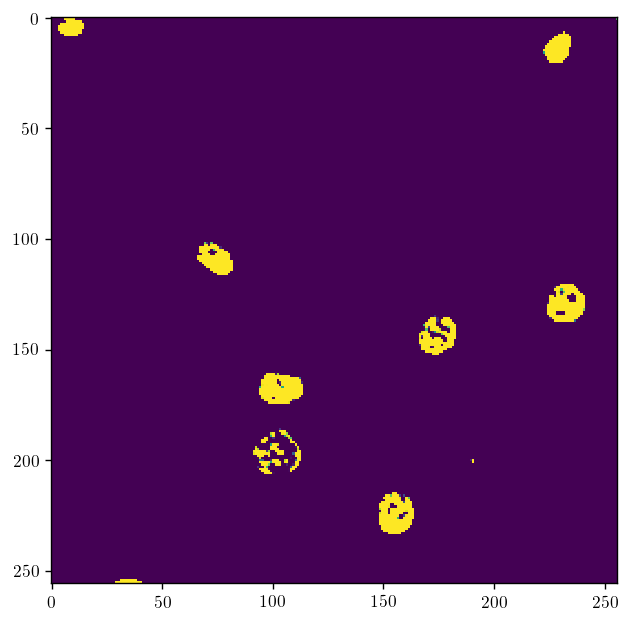

In [150]:
test = unet.predict(x_train_extended[:10])
plt.imshow(test[1kkk, :, :, 0])

In [105]:
import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import *
from keras.models import Model, model_from_yaml
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

In [109]:
from deton8 import metrics

In [ ]:
segmenter_params = {"nms_min_distance": 3, "watershed_line": True}
segmenter = NucleiSegmenter(**segmenter_params)

print("Segmenting nuclei...")

train_components = segmenter.fit_transform(x_train_pred, x_train_pre)
val_components = segmenter.fit_transform(x_val_pred, x_val_pre)

#postprocess(im, min_area=15) for im in x_predictions

#   Print out score for both train and validation